In [123]:
suits = ["Spades", "Clubs", "Diamonds", "Hearts"]
values = ["2", "3", "4", "5", "6", "7", "8", "9", "10", "Jack", "Queen", "King", "Ace"]

import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

class Card:
    def __init__(self, val, suit):
        self.value = val
        self.suit = suit
    
    def show(self):
        print("{} of {}".format(self.value, self.suit))
    
class Deck:
    def __init__(self):
        self.cards = []
        self.build()
        
    def build(self):
        for s in suits:
            for v in values:
                self.cards.append(Card(v,s))
                
    def shuffle(self):
        for i in range(len(self.cards)-1, 0, -1):
            r = random.randint(0,i)
            self.cards[i], self.cards[r] = self.cards[r], self.cards[i]
            
    def drawCard(self):
        x = self.cards.pop()
        return x
            
    def show(self):
        for c in self.cards:
            c.show()

class Player:
    def __init__(self):
        pass
        

In [4]:
# Comparison and Guessing Functions
def compareValue(guess, card):
    if (guess == card.value):
        return 1
    else:
        return 0
    
def bestGuess(cards_seen):
    min_val = min(cards_seen.values())
    bestCards = [key for key in cards_seen if cards_seen[key] == min_val]
    return bestCards[0]

def constantGuess(cards_seen):
    return "2"

def randomGuess(cards_seen):
    size = len(cards_seen)
    idx = random.randint(0,size-1)
    return Card(values[idx], "Spades").value

def realisticGuess(cards_seen):
    while cards_seen["2"] < 4:
        return constantGuess(cards_seen)
    idx = random.randint(1,12)
    return Card(values[idx], "Spades").value

def cardsDone(cards_seen):
    return all([value == 4 for value in cards_seen.values()])

    
def smartGuess(cards_seen, focusNum):
    focus_cards = {}
    unfocus_cards = {}
    for (key, value) in cards_seen.items():
        if any([key == num for num in values[:focusNum]]):
#             print("the values we're focusing on: ", values[:focusNum])
            focus_cards[key] = value
#             print('focus_cards are ', focus_cards)
        else:
            unfocus_cards[key] = value
    if (not cardsDone(focus_cards)):
#         print('focus_cards are NOW ', focus_cards)
        return bestGuess(focus_cards)
#         print('now')
    else:
        return randomGuess(unfocus_cards)

def summarize(technique, data):
    m = min(data)
    M = max(data)
    mean = np.mean(data)
    std = np.std(data)
    print(technique + ": \n    (min, max) = ("
          + str(m) + ", " + str(M) + ")\n    mean = " + str(mean) + "\n    std = " + str(std))

In [97]:
def makeTrials(trials):
    columns = ["focusNum", "mean", "std", "finalWinPct"]
    
    smartData0 = runGame(trials, randomGuess, 0)
    smartData1 = runGame(trials, smartGuess, 1)
    smartData3 = runGame(trials, smartGuess, 3)
    smartData5 = runGame(trials, smartGuess, 5)
    smartData7 = runGame(trials, smartGuess, 7)
    smartData9 = runGame(trials, smartGuess, 9)
    smartData11 = runGame(trials, smartGuess, 11)
    smartData13 = runGame(trials, smartGuess, 13)
    
    df = pd.DataFrame()
    df = df.append(pd.Series([0, np.mean(list(smartData0[51])), np.std(list(smartData0[51])), np.mean(list(smartData0[51]))/52,], columns), ignore_index=True)
    df = df.append(pd.Series([1, np.mean(list(smartData1[51])), np.std(list(smartData1[51])), np.mean(list(smartData1[51]))/52,], columns), ignore_index=True)
    df = df.append(pd.Series([3, np.mean(list(smartData3[51])), np.std(list(smartData3[51])), np.mean(list(smartData3[51]))/52,], columns), ignore_index=True)
    df = df.append(pd.Series([5, np.mean(list(smartData5[51])), np.std(list(smartData5[51])), np.mean(list(smartData5[51]))/52,], columns), ignore_index=True)
    df = df.append(pd.Series([7, np.mean(list(smartData7[51])), np.std(list(smartData7[51])), np.mean(list(smartData7[51]))/52,], columns), ignore_index=True)
    df = df.append(pd.Series([9, np.mean(list(smartData9[51])), np.std(list(smartData9[51])), np.mean(list(smartData9[51]))/52,], columns), ignore_index=True)
    df = df.append(pd.Series([11, np.mean(list(smartData11[51])), np.std(list(smartData11[51])), np.mean(list(smartData11[51]))/52], columns), ignore_index=True)
    df = df.append(pd.Series([13, np.mean(list(smartData13[51])), np.std(list(smartData13[51])), np.mean(list(smartData13[51]))/52], columns), ignore_index=True)
    return df, smartData0, smartData1, smartData3, smartData5, smartData7, smartData9, smartData11, smartData13

def runGame(trials, technique, focusNum):
    deckSize = range(52)
    df = pd.DataFrame(columns=deckSize)
    
    for i in range(trials):
        deck = Deck()
        deck.shuffle()
        cards_seen = {"2":0, "3":0, "4":0, "5":0, "6":0,
                      "7":0, "8":0, "9":0, "10":0, "Jack":0,
                      "Queen":0, "King":0, "Ace":0}
        t = 0
        t_list = []

        for j in deckSize:
            drawnCard = deck.drawCard()
            if technique == smartGuess:
                guess = technique(cards_seen, focusNum)
            else:
                guess = technique(cards_seen)
            score = compareValue(guess, drawnCard)
            cards_seen[drawnCard.value] += 1
            if score == 1:
                t += 1
            t_list.append(t)

        df = df.append(pd.Series(t_list, index=deckSize), ignore_index=True)
    
    scores = list(df[51])
    summarize(str(technique), scores)
    
    return df

def plotHist(data, figTitle):
    fig, ax = plt.subplots(figsize = (6,4))
    
    mean = data[51].mean()
    
    scores = data[51]
    binNum = max(scores) - min(scores)
    if binNum == 0:
        binNum += 2
    ax.hist(scores, alpha=0.7, bins=binNum, color="steelblue")
    ax.set_xticks(range(max(scores)+1))
    ax.axvline(x=mean, color="darkred", label="average score: " + str(round(mean, 2)))
    
    ax.set_title("Score Distribution, Guessing Realistic")
    ax.set_xlabel("Final Score")
    ax.set_ylabel("Frequency")
    ax.legend()
    fig.savefig(figTitle)
    
def plotManyHist(datalist, figTitle):
    fig, ax = plt.subplots(figsize = (12,6))
    
    size = len(datalist)
    scores = [] 
    for i in range(size):
        scores.append(datalist[i][51])
        mean = datalist[i][51].mean()
        binNum = max(scores[i]) - min(scores[i])
        if binNum == 0:
            binNum += 2
        ax.hist(scores[i], alpha=0.7, bins=binNum)
        ax.set_xticks(range(max(scores[i])+1))
        ax.axvline(x=mean, color="darkred", label="average score: " + str(round(mean, 2)))
        ax.set_title("Score Distribution, Best Strategy")
        ax.set_xlabel("Final Score")
        ax.set_ylabel("Frequency")
        ax.grid('both')
    
    ax.legend()
    fig.savefig(figTitle)
    
    
def plotScores(data, title):
    fig, lines = plt.subplots(figsize = (8, 6))
    lines.plot(data.mean())
    
    
    lines.grid('both')
    lines.set_title("Average Scoring Trend, Playing the Best Strategy")
    lines.set_ylim(0,10)
    lines.set_yticks(range(11))
    lines.set_xlabel("# of Cards Seen")
    lines.set_ylabel("Score")
    fig.savefig(title)
    
def plotManyScores(datalist, dataTitles, title):
    fig, lines = plt.subplots(figsize = (8, 6))
    
    size = len(datalist)
    for i in [4,3,2,1,0]:
        lines.plot(datalist[i].mean(), label=dataTitles[i])
        lines.grid('both')
        lines.set_title("Comparing Average Scoring Trends Across Guessing Strategies")
        lines.set_ylim(0,10)
        lines.set_yticks(range(11))
    
    lines.set_xlabel("# of Cards Seen")
    lines.set_ylabel("Score")
    lines.legend(loc="best")
    fig.savefig(title)
    
def plotOneScore(data, title):
    fig, lines = plt.subplots(figsize = (8, 6))
    lines.plot(data.mean())
    
    top = int(max(data.mean()))
    
    lines.grid('both')
    lines.set_title("Score Over Time, Playing the Best Strategy")
    lines.set_ylim(0,top)
    lines.set_yticks(range(top + 2))
    lines.set_xlabel("# of Cards Seen")
    lines.set_ylabel("Score")
    fig.savefig(title)

In [110]:
%%time
df, smartData0, smartData1, smartData3, smartData5, smartData7, smartData9, smartData11, smartData13 = makeTrials(10000)

<function randomGuess at 0x1a0e5baae8>: 
    (min, max) = (0, 12)
    mean = 4.0198
    std = 1.9172396720285132
<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 12)
    mean = 4.7369
    std = 1.0361845347234244
<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 13)
    mean = 6.3463
    std = 1.3479526364082677
<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 15)
    mean = 7.2742
    std = 1.6079845646025337
<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 16)
    mean = 7.9157
    std = 1.7884052980239127
<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 17)
    mean = 8.4524
    std = 1.9078611689533385
<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 17)
    mean = 8.8324
    std = 2.02329193148196
<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 18)
    mean = 9.2101
    std = 2.1073580592770655
CPU times: user 4min 58s, sys: 36.9 s, total: 5min 35s
Wall time: 5min 57s


In [112]:
df

,finalWinPct,focusNum,mean,std
0,0.077304,0.0,4.0198,1.917240
1,0.091094,1.0,4.7369,1.036185
2,0.122044,3.0,6.3463,1.347953
3,0.139888,5.0,7.2742,1.607985
4,0.152225,7.0,7.9157,1.788405
5,0.162546,9.0,8.4524,1.907861
6,0.169854,11.0,8.8324,2.023292
7,0.177117,13.0,9.2101,2.107358


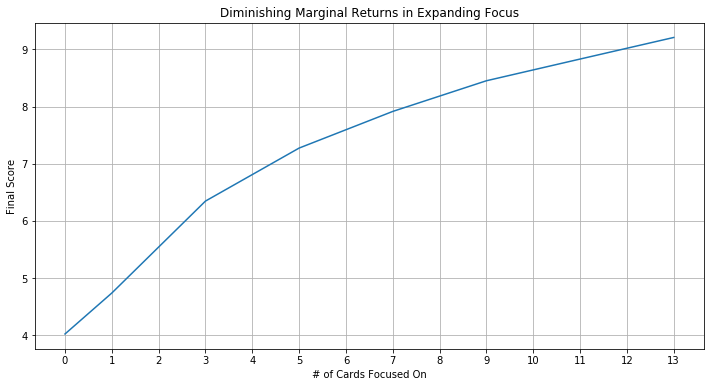

In [126]:
fig, ax = plt.subplots(figsize=(12,6))
x = [0, 1, 3, 5, 7, 9, 11, 13]
ax.plot(x, df["mean"])
ax.grid('both')
ax.set_xlabel("# of Cards Focused On")
ax.set_ylabel("Final Score")
ax.set_title("Diminishing Marginal Returns in Expanding Focus")
ax.set_xticks(range(14))
fig.savefig("diminishingMarg.png")

In [94]:
%%time
scoresBest = runGame(1, smartGuess, 13)

<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (12, 12)
    mean = 12.0
    std = 0.0
CPU times: user 10.7 ms, sys: 548 µs, total: 11.3 ms
Wall time: 11 ms


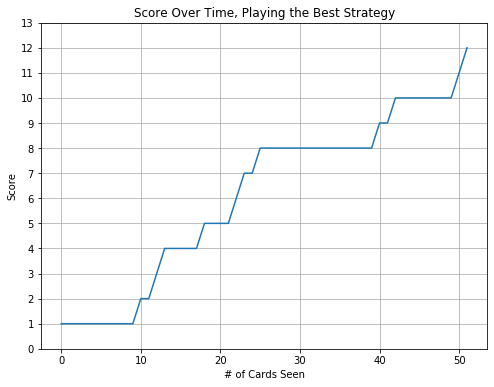

In [95]:
plotOneScore(scoresBest, "score2.png")

In [11]:
%%time
df13 = runGame(10000, smartGuess, 13)

<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 19)
    mean = 9.2209
    std = 2.117192289330376
CPU times: user 40.3 s, sys: 4.25 s, total: 44.6 s
Wall time: 46.2 s


In [69]:
df2 = runGame(10000, smartGuess, 2)

<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 12)
    mean = 5.686
    std = 1.1635308332829002


In [60]:
%%time
df0 = runGame(10000, randomGuess, 1)
df2 = runGame(10000, randomGuess, 2)
df5 = runGame(10000, smartGuess, 5)
df10 = runGame(10000, smartGuess, 10)

<function randomGuess at 0x1a0e5baae8>: 
    (min, max) = (0, 12)
    mean = 3.9875
    std = 1.9370967322258328
<function randomGuess at 0x1a0e5baae8>: 
    (min, max) = (0, 12)
    mean = 4.0187
    std = 1.9563614977810209
<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 13)
    mean = 7.2652
    std = 1.5862751841972436
<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 18)
    mean = 8.6318
    std = 1.97646876018823
CPU times: user 2min 17s, sys: 18.3 s, total: 2min 35s
Wall time: 2min 39s


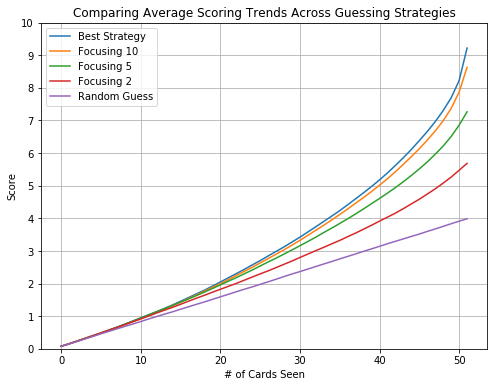

In [88]:
plotManyScores([df0, df2, df5, df10, df13], ["Random Guess", "Focusing 2", "Focusing 5", "Focusing 10", "Best Strategy"], "comparingAvgScores.png")

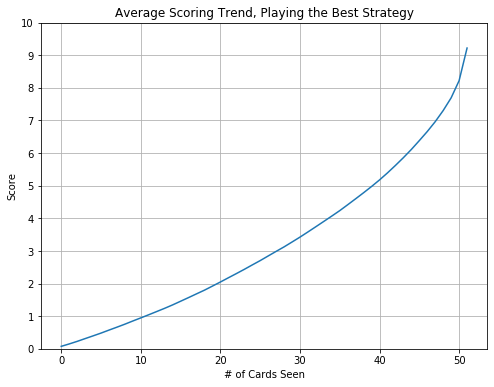

In [89]:
plotScores(df13, "averageBestScores.png")

In [124]:
%%time
realistic = runGame(10000, smartGuess, 1)

<function smartGuess at 0x1a0e5bad08>: 
    (min, max) = (4, 12)
    mean = 4.7342
    std = 1.041129367561976
CPU times: user 34.1 s, sys: 4.39 s, total: 38.4 s
Wall time: 39.3 s


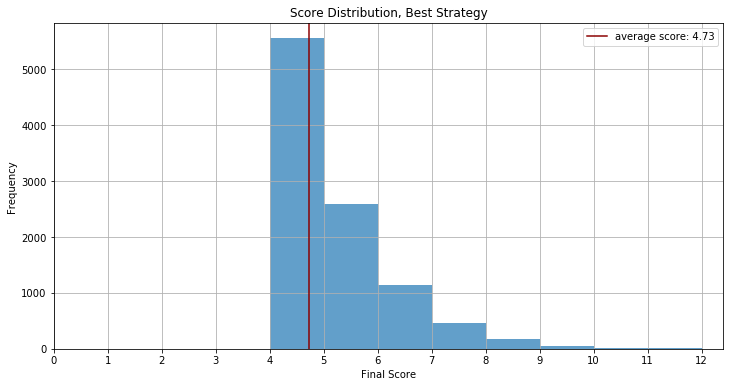

In [125]:
plotManyHist([realistic], "realisticHist.png")

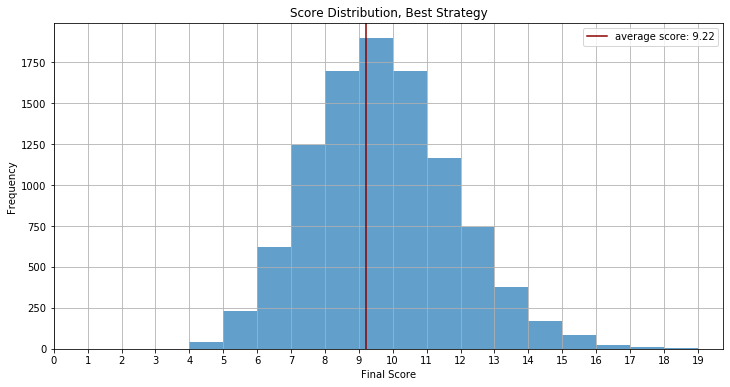

In [12]:
plotManyHist([df13], "best.png")

In [ ]:
%%time
df = runGame(10000, realisticGuess, 1)

In [ ]:
plotHist(df, "realistic.png")

In [ ]:
plotScores(df)

In [ ]:
%%time
df, data1, data3, data5, data7, data9, data11, data13 = makeTrials(10000)

In [ ]:
df

In [ ]:
# plt.plot(df['mean'])
# plt.plot(df['std'])
plt.plot(df['finalWinPct'])

In [ ]:
df['finalWinPct']

In [ ]:
df = makeTrials(100)

In [ ]:
df[0]

In [ ]:
plotGame([realisticData, smartData1, smartData13, bestData])

In [ ]:
%%time
bestData = runGame(10000, bestGuess)

In [ ]:
%%time
randomData = runGame(10000, randomGuess)

In [ ]:
%%time
realisticData = runGame(10000, realisticGuess)

In [ ]:
%%time
constantData = runGame(10000, constantGuess)

In [ ]:
type(list(x[51]))

In [ ]:
def times(x, y):
    return x*y

def add(x, y):
    return x+y

def chooseFunction(operator, p1, p2):
    return operator(p1,p2)

In [ ]:
chooseFunction(times, 2, 3)

In [ ]:
%%time
x = Game(10000, bestGuess)

In [ ]:
x[0].mean()

In [ ]:
columns

In [ ]:
df4

In [ ]:
plt.plot(x.mean())

In [ ]:
import pandas as pd
columns = range(6)
data = [0, 0, 1, 1, 1, 2]
df = pd.DataFrame(columns=columns)
df

In [ ]:
row = pd.Series(data, index=columns)
row2 = pd.Series([0,1,2, 2, 2, 2], index=columns)

In [ ]:
df = df.append(row, ignore_index=True)
df = df.append(row2, ignore_index=True)
df

In [ ]:
data2 = [0, 1, 2, 3, 4, 5]
df2 = pd.DataFrame(data2)
df2 = df2.transpose()
df2

In [ ]:
df3 = df.append(df2)
df3

In [ ]:
row = pd.Series([0,1,2])
row2 = pd.Series([0])
df.append(row, ignore_index=True)
df.append(row2, ignore_index=True)

In [ ]:
df.append(row2, ignore_index=True)

In [ ]:
deck = Deck()
deck.shuffle()
deck.show()

In [ ]:
deck.show()

In [ ]:
deck.drawCard()

In [ ]:
deck.show()